In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ct-to-mri-cgan/Dataset/sources.txt
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1860.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1979.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri99.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri478.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1608.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1379.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri2058.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1589.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri678.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri2440.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri959.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri750.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri1628.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri2288.jpg
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB/mri699.jpg
/kaggle/input/ct-to-mri-cgan

In [2]:
# %% 1) Install dependencies (if not present)
try:
    import pytorch_fid
    import lpips
    import cv2
except Exception:
    !pip install --quiet pytorch-fid lpips opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 94.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
DATA_ROOT = '/kaggle/input/ct-to-mri-cgan/Dataset/images'

for root, dirs, files in os.walk(DATA_ROOT):
    print(root, len(files), "files")

/kaggle/input/ct-to-mri-cgan/Dataset/images 0 files
/kaggle/input/ct-to-mri-cgan/Dataset/images/testB 744 files
/kaggle/input/ct-to-mri-cgan/Dataset/images/testA 744 files
/kaggle/input/ct-to-mri-cgan/Dataset/images/trainB 1744 files
/kaggle/input/ct-to-mri-cgan/Dataset/images/trainA 1742 files


In [4]:
import os, glob, random, time, csv
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import cv2 # Added for Grad-CAM visualization utility

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms as T
from torchvision.utils import save_image, make_grid
from skimage.metrics import mean_squared_error, normalized_root_mse
from skimage.transform import resize
import torch.nn.functional as F

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# FID & LPIPS
from pytorch_fid.fid_score import calculate_fid_given_paths
import lpips

2025-10-18 18:14:59.919324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760811300.155630      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760811300.222299      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_lpips = lpips.LPIPS(net='alex').to(device)

def calculate_mse_rmse(img1, img2):
    """Calculates MSE and RMSE for normalized numpy images [0, 1]."""
    # Convert from torch tensor [-1, 1] to numpy [0, 1]
    img1_np = ((img1.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2).mean(axis=2)
    img2_np = ((img2.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2).mean(axis=2)
    
    mse = mean_squared_error(img1_np, img2_np)
    rmse = np.sqrt(mse)
    return mse, rmse

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 207MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [6]:
# Average meter class for logging
class AverageMeter:
    def __init__(self): 
        self.reset()
    def reset(self): 
        self.val = self.sum = self.count = self.avg = 0.0
    def update(self, val, n=1):
        self.val = float(val); self.sum += float(val) * n; self.count += n; self.avg = self.sum / self.count

In [7]:
# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [8]:
# --- Hyperparams ---
DATA_ROOT = '/kaggle/input/ct-to-mri-cgan/Dataset/images'
IMAGE_SIZE = 256
BATCH_SIZE = 4
NUM_WORKERS = 2
N_EPOCHS = 100
LR = 2e-4
BETA1, BETA2 = 0.5, 0.999
POOL_SIZE = 50
LAMBDA_NCE = 5.0  # Weight for NCE loss in CUT
LAMBDA_Z = 1.0
SAVE_EVERY = 5

# latent dims
Z_DIM = 8
Z_MAP_CHANNELS = 1

OUT_DIR = '/kaggle/working/cutgan_outputs'
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, 'samples'), exist_ok=True)

# dataset folders (train for training, test for evaluation)
TRAIN_CT_FOLDER = os.path.join(DATA_ROOT, 'trainA')  # CT (A)
TRAIN_MRI_FOLDER = os.path.join(DATA_ROOT, 'trainB')  # MRI (B)
TEST_CT_FOLDER = os.path.join(DATA_ROOT, 'testA')  # Test CT
TEST_MRI_FOLDER = os.path.join(DATA_ROOT, 'testB')  # Test MRI

print('TRAIN_CT_FOLDER =', TRAIN_CT_FOLDER)
print('TRAIN_MRI_FOLDER =', TRAIN_MRI_FOLDER)
print('TEST_CT_FOLDER =', TEST_CT_FOLDER)
print('TEST_MRI_FOLDER =', TEST_MRI_FOLDER)

# sanity checks
assert os.path.isdir(TRAIN_CT_FOLDER), f"Train CT folder not found: {TRAIN_CT_FOLDER}"
assert os.path.isdir(TRAIN_MRI_FOLDER), f"Train MRI folder not found: {TRAIN_MRI_FOLDER}"
assert os.path.isdir(TEST_CT_FOLDER), f"Test CT folder not found: {TEST_CT_FOLDER}"
assert os.path.isdir(TEST_MRI_FOLDER), f"Test MRI folder not found: {TEST_MRI_FOLDER}"

writer = SummaryWriter(log_dir=os.path.join(OUT_DIR, 'logs'))

# metrics CSV init (no ms_ssim)
metrics_csv = os.path.join(OUT_DIR, 'metrics.csv')
with open(metrics_csv, 'w', newline='') as f:
    writer_csv = csv.writer(f)
    writer_csv.writerow(['epoch','iteration','loss_G','loss_D_A','loss_D_B',
                         'loss_gan_A2B','loss_gan_B2A',
                         'loss_nce_A2B','loss_nce_B2A','loss_z','lr','fid','lpips','psnr','ssim',
                         'rmse', 'mse'])

TRAIN_CT_FOLDER = /kaggle/input/ct-to-mri-cgan/Dataset/images/trainA
TRAIN_MRI_FOLDER = /kaggle/input/ct-to-mri-cgan/Dataset/images/trainB
TEST_CT_FOLDER = /kaggle/input/ct-to-mri-cgan/Dataset/images/testA
TEST_MRI_FOLDER = /kaggle/input/ct-to-mri-cgan/Dataset/images/testB


In [9]:
# ---------- Utility: Image -> PIL ----------
def img_to_pil(img_path):
    return Image.open(img_path).convert('RGB')

class UnpairedImageDataset(Dataset):
    def __init__(self, dir_A, dir_b, transform=None):
        self.A_paths = sorted([os.path.join(dir_A, f) for f in os.listdir(dir_A) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.B_paths = sorted([os.path.join(dir_b, f) for f in os.listdir(dir_b) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        if len(self.A_paths) == 0: raise RuntimeError(f'No images in {dir_A}')
        if len(self.B_paths) == 0: raise RuntimeError(f'No images in {dir_b}')
        self.transform = transform

    def __len__(self): return max(len(self.A_paths), len(self.B_paths))

    def __getitem__(self, idx):
        A_path = self.A_paths[idx % len(self.A_paths)]
        B_path = random.choice(self.B_paths)
        A_img = img_to_pil(A_path)
        B_img = img_to_pil(B_path)
        if self.transform:
            A = self.transform(A_img)
            B = self.transform(B_img)
        else:
            A = T.ToTensor()(A_img)
            B = T.ToTensor()(B_img)
        return {'A': A, 'B': B, 'A_paths': A_path, 'B_paths': B_path}

transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Train dataset
train_dataset = UnpairedImageDataset(TRAIN_CT_FOLDER, TRAIN_MRI_FOLDER, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
print('Train Dataset size =', len(train_dataset))

# Test dataset (no augmentation for evaluation)
test_transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
test_dataset = UnpairedImageDataset(TEST_CT_FOLDER, TEST_MRI_FOLDER, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print('Test Dataset size =', len(test_dataset))

Train Dataset size = 1744
Test Dataset size = 744


In [10]:
# ---------- Models ----------
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        block = []
        block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, bias=False), nn.InstanceNorm2d(dim), nn.ReLU(True)]
        block += [nn.ReflectionPad2d(1), nn.Conv2d(dim, dim, kernel_size=3, bias=False), nn.InstanceNorm2d(dim)]
        self.block = nn.Sequential(*block)

    def forward(self, x):
        return x + self.block(x)

class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, n_blocks=6):
        super().__init__()
        model = []
        model += [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, bias=False), nn.InstanceNorm2d(ngf), nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=False),
                      nn.InstanceNorm2d(ngf * mult * 2), nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                      nn.InstanceNorm2d(int(ngf * mult / 2)), nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3), nn.Conv2d(ngf, output_nc, kernel_size=7), nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        super().__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]

        nf_mult = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        self.model = nn.Sequential(*sequence)

    def forward(self, x):
        return self.model(x)

In [11]:
def init_weights(net, init_type='normal', init_gain=0.02):
    def init_fun(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1 or classname.find('InstanceNorm2d') != -1:
            try:
                nn.init.normal_(m.weight.data, 1.0, init_gain)
                nn.init.constant_(m.bias.data, 0.0)
            except Exception:
                pass
    net.apply(init_fun)

In [12]:
# ---------- Latent Encoder (modified to return feature map) ----------
class LatentEncoder(nn.Module):
    """Encode images to a latent vector z (Z_DIM) and feature map."""
    def __init__(self, input_nc=3, z_dim=Z_DIM, ndf=64):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_nc, ndf, 4, 2, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1), nn.InstanceNorm2d(ndf*2), nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1), nn.InstanceNorm2d(ndf*4), nn.LeakyReLU(0.2, True),
        )
        # global pooling to vector
        self.fc = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(ndf*4, z_dim))

    def forward(self, x):
        f = self.conv(x)
        z = self.fc(f)
        return z, f  # return z and feature map f: B, 256, 32, 32

In [13]:
# ---------- Instantiate networks ----------
netG_A2B = ResnetGenerator(3 + Z_MAP_CHANNELS, 3, ngf=64, n_blocks=6).to(device)
netG_B2A = ResnetGenerator(3 + Z_MAP_CHANNELS, 3, ngf=64, n_blocks=6).to(device)
netD_A = NLayerDiscriminator(3).to(device)
netD_B = NLayerDiscriminator(3).to(device)
netE = LatentEncoder(input_nc=3, z_dim=Z_DIM).to(device)

init_weights(netG_A2B)
init_weights(netG_B2A)
init_weights(netD_A)
init_weights(netD_B)
init_weights(netE)

In [14]:
# ---------- Losses, optimizers, schedulers, pools ----------
criterion_GAN = nn.MSELoss()
criterion_z = nn.L1Loss()

# PatchNCE Loss for CUT
def patchnce_loss(feat_q, feat_k, tau=0.07):
    B, C, H, W = feat_q.shape
    S = H * W
    feat_q = feat_q.reshape(B, C, S).permute(0, 2, 1).reshape(-1, C)  # (B*S), C
    feat_k = feat_k.reshape(B, C, S).permute(0, 2, 1).reshape(-1, C)  # (B*S), C
    feat_q = F.normalize(feat_q, dim=-1)
    feat_k = F.normalize(feat_k, dim=-1)
    logits = torch.matmul(feat_q, feat_k.t()) / tau  # (BS) x (BS)
    labels = torch.arange(B * S).to(logits.device)
    return F.cross_entropy(logits, labels)

optimizer_G = optim.Adam(list(netG_A2B.parameters()) + list(netG_B2A.parameters()), lr=LR, betas=(BETA1, BETA2))
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=LR, betas=(BETA1, BETA2))
optimizer_E = optim.Adam(netE.parameters(), lr=LR, betas=(BETA1, BETA2))

def lambda_rule(epoch):
    start_decay_epoch = int(N_EPOCHS / 2)
    if epoch < start_decay_epoch:
        return 1.0
    return 1.0 - float(epoch - start_decay_epoch) / (N_EPOCHS - start_decay_epoch + 1)

scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D_A = optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_rule)
scheduler_D_B = optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_rule)
scheduler_E = optim.lr_scheduler.LambdaLR(optimizer_E, lr_lambda=lambda_rule)

class ImagePool:
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        if pool_size > 0:
            self.images = []
            self.num_imgs = 0

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs += 1
                self.images.append(image.clone())
                return_images.append(image)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.pool_size - 1)
                    tmp = self.images[idx].clone()
                    self.images[idx] = image.clone()
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return torch.cat(return_images, 0)

fake_A_pool = ImagePool(POOL_SIZE)
fake_B_pool = ImagePool(POOL_SIZE)

def make_target(pred, target_is_real=True):
    return torch.ones_like(pred, device=pred.device) if target_is_real else torch.zeros_like(pred, device=pred.device)

def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

In [15]:
# ---------- DiffAugment ----------
def diff_augment(x, policy='color,translation,cutout'):
    out = (x + 1) / 2.0
    B, C, H, W = out.shape
    if 'color' in policy:
        b = (torch.rand(B, 1, 1, 1, device=out.device) * 0.2) + 0.9
        c = (torch.rand(B, 1, 1, 1, device=out.device) * 0.2) + 0.9
        out = out * c + (b - 1.0)
        out = out.clamp(0, 1)
    if 'translation' in policy:
        max_shift = int(0.125 * H)
        if max_shift > 0:
            shift_x = torch.randint(-max_shift, max_shift+1, (B,), device=out.device)
            shift_y = torch.randint(-max_shift, max_shift+1, (B,), device=out.device)
            res = torch.zeros_like(out)
            for i in range(B):
                sx = shift_x[i].item(); sy = shift_y[i].item()
                src = out[i]
                dst = res[i]
                x1 = max(0, sx); x2 = min(W, W+sx)
                y1 = max(0, sy); y2 = min(H, H+sy)
                sx1 = max(0, -sx); sx2 = sx1 + (x2-x1)
                sy1 = max(0, -sy); sy2 = sy1 + (y2-y1)
                dst[:, y1:y2, x1:x2] = src[:, sy1:sy2, sx1:sx2]
            out = res
    if 'cutout' in policy:
        cut_w = int(0.2*W); cut_h = int(0.2*H)
        for i in range(B):
            cx = random.randint(0, W)
            cy = random.randint(0, H)
            x1 = max(0, cx - cut_w//2); x2 = min(W, cx + cut_w//2)
            y1 = max(0, cy - cut_h//2); y2 = min(H, cy + cut_h//2)
            out[i, :, y1:y2, x1:x2] = 0.5
    return out * 2.0 - 1.0

In [16]:
# ---------- Helpers ----------
def sample_z_map(batch_size, z_dim, H, W, device):
    z = torch.randn(batch_size, z_dim, device=device)
    z_mean = z.mean(dim=1, keepdim=True)
    z_map = z_mean.view(batch_size, 1, 1, 1).expand(batch_size, 1, H, W)
    return z, z_map
print('Starting training with CUT (Contrastive Unpaired Translation)...')

iteration = 0
meter_G = AverageMeter()
meter_D_A = AverageMeter()
meter_D_B = AverageMeter()
meter_gan_A2B = AverageMeter()
meter_gan_B2A = AverageMeter()
meter_nce_A2B = AverageMeter()
meter_nce_B2A = AverageMeter()
meter_z = AverageMeter()

for epoch in range(1, N_EPOCHS + 1):
    t0 = time.time()
    netG_A2B.train(); netG_B2A.train(); netD_A.train(); netD_B.train(); netE.train()
    loop = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch}/{N_EPOCHS}")
    for i, data in loop:
        real_A, real_B = data['A'].to(device), data['B'].to(device)

        # Train Generators + Encoder
        optimizer_G.zero_grad()
        optimizer_E.zero_grad()

        B_size = real_A.size(0)
        _, _, H, W = real_A.shape
        z_A, z_map_A = sample_z_map(B_size, Z_DIM, H, W, device)
        z_B, z_map_B = sample_z_map(B_size, Z_DIM, H, W, device)

        # GAN forward
        fake_B = netG_A2B(torch.cat([real_A, z_map_A], dim=1))
        pred_fake_B = netD_B(diff_augment(fake_B))
        loss_GAN_A2B = criterion_GAN(pred_fake_B, make_target(pred_fake_B, True))

        fake_A = netG_B2A(torch.cat([real_B, z_map_B], dim=1))
        pred_fake_A = netD_A(diff_augment(fake_A))
        loss_GAN_B2A = criterion_GAN(pred_fake_A, make_target(pred_fake_A, True))

        # CUT Contrastive Loss (FIXED: Use feature maps for spatial patches)
        _, feat_input_A = netE(real_A)  # 4D feature map from input A
        _, feat_output_B = netE(fake_B)  # 4D from generated B
        loss_nce_A2B = patchnce_loss(feat_output_B, feat_input_A)

        _, feat_input_B = netE(real_B)  # 4D from input B
        _, feat_output_A = netE(fake_A)  # 4D from generated A
        loss_nce_B2A = patchnce_loss(feat_output_A, feat_input_B)

        # Latent reconstruction (uses 2D z correctly)
        z_A_input, _ = netE(real_A)
        z_B_input, _ = netE(real_B)
        z_rec_from_fakeB, _ = netE(fake_B)
        z_rec_from_fakeA, _ = netE(fake_A)
        loss_z = (criterion_z(z_rec_from_fakeB, z_A_input) + criterion_z(z_rec_from_fakeA, z_B_input)) * LAMBDA_Z

        # Total G loss (no cycle or identity)
        loss_G = loss_GAN_A2B + loss_GAN_B2A + loss_nce_A2B * LAMBDA_NCE + loss_nce_B2A * LAMBDA_NCE + loss_z
        loss_G.backward()
        optimizer_G.step()
        optimizer_E.step()

        # Train D_A (unchanged)
        optimizer_D_A.zero_grad()
        pred_real_A = netD_A(diff_augment(real_A))
        loss_D_real_A = criterion_GAN(pred_real_A, make_target(pred_real_A, True))

        fake_A_det = fake_A_pool.query(fake_A.detach())
        pred_fake_A = netD_A(diff_augment(fake_A_det))
        loss_D_fake_A = criterion_GAN(pred_fake_A, make_target(pred_fake_A, False))

        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

        # Train D_B (unchanged)
        optimizer_D_B.zero_grad()
        pred_real_B = netD_B(diff_augment(real_B))
        loss_D_real_B = criterion_GAN(pred_real_B, make_target(pred_real_B, True))

        fake_B_det = fake_B_pool.query(fake_B.detach())
        pred_fake_B = netD_B(diff_augment(fake_B_det))
        loss_D_fake_B = criterion_GAN(pred_fake_B, make_target(pred_fake_B, False))

        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

        # Update meters (unchanged)
        iteration += 1
        meter_G.update(loss_G.item())
        meter_D_A.update(loss_D_A.item())
        meter_D_B.update(loss_D_B.item())
        meter_gan_A2B.update(loss_GAN_A2B.item())
        meter_gan_B2A.update(loss_GAN_B2A.item())
        meter_nce_A2B.update(loss_nce_A2B.item())
        meter_nce_B2A.update(loss_nce_B2A.item())
        meter_z.update(loss_z.item())

        # Logging (unchanged)
        if iteration % 50 == 0:
            writer.add_scalar('Loss/loss_G', meter_G.avg, iteration)
            writer.add_scalar('Loss/loss_D_A', meter_D_A.avg, iteration)
            writer.add_scalar('Loss/loss_D_B', meter_D_B.avg, iteration)
            writer.add_scalar('Loss/loss_nce_A2B', meter_nce_A2B.avg, iteration)
            writer.add_scalar('Loss/loss_z', meter_z.avg, iteration)
            writer.add_scalar('LR/lr_G', get_lr(optimizer_G), iteration)

        if iteration % 500 == 0:
            with torch.no_grad():
                sample = torch.cat([real_A[:2], fake_B[:2], real_B[:2], fake_A[:2]], 0)
                sample_img = (sample + 1) / 2.0
                grid_img = make_grid(sample_img, nrow=2, padding=2, normalize=False)
                save_image(sample_img, os.path.join(OUT_DIR, 'samples', f'iter_{iteration}.png'), nrow=2)
                writer.add_image('Samples/iter', grid_img, iteration)

        loop.set_postfix({
            'G': f'{meter_G.avg:.4f}',
            'D_A': f'{meter_D_A.avg:.4f}',
            'D_B': f'{meter_D_B.avg:.4f}',
            'NCE_A2B': f'{meter_nce_A2B.avg:.4f}',
            'Z': f'{meter_z.avg:.4f}'
        })

    # Scheduler step (unchanged)
    scheduler_G.step()
    scheduler_D_A.step()
    scheduler_D_B.step()
    scheduler_E.step()

    # Save checkpoint (unchanged)
    if epoch % SAVE_EVERY == 0 or epoch == N_EPOCHS:
        ckpt_path = os.path.join(OUT_DIR, 'checkpoints', f'ckpt_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'netG_A2B': netG_A2B.state_dict(),
            'netG_B2A': netG_B2A.state_dict(),
            'netD_A': netD_A.state_dict(),
            'netD_B': netD_B.state_dict(),
            'netE': netE.state_dict(),
            'optimizer_G': optimizer_G.state_dict(),
            'optimizer_E': optimizer_E.state_dict(),
            'scheduler_G': scheduler_G.state_dict(),
            'scheduler_E': scheduler_E.state_dict()
        }, ckpt_path)

    # Log to CSV (unchanged)
    with open(metrics_csv, 'a', newline='') as f:
        writer_csv = csv.writer(f)
        writer_csv.writerow([
            epoch, iteration, meter_G.avg, meter_D_A.avg, meter_D_B.avg,
            meter_gan_A2B.avg, meter_gan_B2A.avg,
            meter_nce_A2B.avg, meter_nce_B2A.avg, meter_z.avg, get_lr(optimizer_G),
            '', '', '', '', '', ''
        ])

    t1 = time.time()
    print(f"Epoch {epoch} finished in {t1-t0:.1f}s - G: {meter_G.avg:.4f}, D_A: {meter_D_A.avg:.4f}, D_B: {meter_D_B.avg:.4f}, NCE_A2B: {meter_nce_A2B.avg:.4f}, Z: {meter_z.avg:.4f}")

print('Training finished.')
writer.close()

Starting training with CUT (Contrastive Unpaired Translation)...


Epoch 1/100: 100%|██████████| 436/436 [03:11<00:00,  2.28it/s, G=22.9880, D_A=0.3114, D_B=0.3259, NCE_A2B=2.7976, Z=0.0032]

Epoch 1 finished in 191.5s - G: 22.9880, D_A: 0.3114, D_B: 0.3259, NCE_A2B: 2.7976, Z: 0.0032



Epoch 2/100: 100%|██████████| 436/436 [03:10<00:00,  2.28it/s, G=19.5710, D_A=0.2572, D_B=0.2608, NCE_A2B=2.5124, Z=0.0021]

Epoch 2 finished in 190.9s - G: 19.5710, D_A: 0.2572, D_B: 0.2608, NCE_A2B: 2.5124, Z: 0.0021



Epoch 3/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=18.2127, D_A=0.2381, D_B=0.2377, NCE_A2B=2.3958, Z=0.0017]

Epoch 3 finished in 190.6s - G: 18.2127, D_A: 0.2381, D_B: 0.2377, NCE_A2B: 2.3958, Z: 0.0017



Epoch 4/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=17.7958, D_A=0.2264, D_B=0.2261, NCE_A2B=2.3623, Z=0.0015]

Epoch 4 finished in 190.5s - G: 17.7958, D_A: 0.2264, D_B: 0.2261, NCE_A2B: 2.3623, Z: 0.0015



Epoch 5/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=17.2792, D_A=0.2352, D_B=0.2209, NCE_A2B=2.3202, Z=0.0013]


Epoch 5 finished in 190.8s - G: 17.2792, D_A: 0.2352, D_B: 0.2209, NCE_A2B: 2.3202, Z: 0.0013


Epoch 6/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=16.9090, D_A=0.2299, D_B=0.2133, NCE_A2B=2.2896, Z=0.0011]

Epoch 6 finished in 190.4s - G: 16.9090, D_A: 0.2299, D_B: 0.2133, NCE_A2B: 2.2896, Z: 0.0011



Epoch 7/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=16.6251, D_A=0.2255, D_B=0.2103, NCE_A2B=2.2660, Z=0.0010]

Epoch 7 finished in 190.4s - G: 16.6251, D_A: 0.2255, D_B: 0.2103, NCE_A2B: 2.2660, Z: 0.0010



Epoch 8/100: 100%|██████████| 436/436 [03:09<00:00,  2.30it/s, G=16.5360, D_A=0.2165, D_B=0.2064, NCE_A2B=2.2546, Z=0.0009]

Epoch 8 finished in 190.0s - G: 16.5360, D_A: 0.2165, D_B: 0.2064, NCE_A2B: 2.2546, Z: 0.0009



Epoch 9/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=16.3690, D_A=0.2117, D_B=0.2030, NCE_A2B=2.2398, Z=0.0008]

Epoch 9 finished in 190.3s - G: 16.3690, D_A: 0.2117, D_B: 0.2030, NCE_A2B: 2.2398, Z: 0.0008



Epoch 10/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=16.2256, D_A=0.2084, D_B=0.2002, NCE_A2B=2.2266, Z=0.0007]


Epoch 10 finished in 190.6s - G: 16.2256, D_A: 0.2084, D_B: 0.2002, NCE_A2B: 2.2266, Z: 0.0007


Epoch 11/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=16.0963, D_A=0.2059, D_B=0.1973, NCE_A2B=2.2155, Z=0.0007]

Epoch 11 finished in 190.4s - G: 16.0963, D_A: 0.2059, D_B: 0.1973, NCE_A2B: 2.2155, Z: 0.0007



Epoch 12/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=16.0928, D_A=0.2037, D_B=0.2073, NCE_A2B=2.2174, Z=0.0007]

Epoch 12 finished in 190.7s - G: 16.0928, D_A: 0.2037, D_B: 0.2073, NCE_A2B: 2.2174, Z: 0.0007



Epoch 13/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=16.0105, D_A=0.2005, D_B=0.2052, NCE_A2B=2.2097, Z=0.0006]

Epoch 13 finished in 190.3s - G: 16.0105, D_A: 0.2005, D_B: 0.2052, NCE_A2B: 2.2097, Z: 0.0006



Epoch 14/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.9025, D_A=0.2002, D_B=0.2045, NCE_A2B=2.2006, Z=0.0006]

Epoch 14 finished in 190.3s - G: 15.9025, D_A: 0.2002, D_B: 0.2045, NCE_A2B: 2.2006, Z: 0.0006



Epoch 15/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.8219, D_A=0.1995, D_B=0.2018, NCE_A2B=2.1939, Z=0.0005]


Epoch 15 finished in 190.6s - G: 15.8219, D_A: 0.1995, D_B: 0.2018, NCE_A2B: 2.1939, Z: 0.0005


Epoch 16/100: 100%|██████████| 436/436 [03:09<00:00,  2.30it/s, G=15.7477, D_A=0.1984, D_B=0.1996, NCE_A2B=2.1868, Z=0.0005]

Epoch 16 finished in 189.9s - G: 15.7477, D_A: 0.1984, D_B: 0.1996, NCE_A2B: 2.1868, Z: 0.0005



Epoch 17/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.7060, D_A=0.1959, D_B=0.1968, NCE_A2B=2.1819, Z=0.0005]

Epoch 17 finished in 190.2s - G: 15.7060, D_A: 0.1959, D_B: 0.1968, NCE_A2B: 2.1819, Z: 0.0005



Epoch 18/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.6568, D_A=0.1943, D_B=0.1953, NCE_A2B=2.1770, Z=0.0005]

Epoch 18 finished in 190.3s - G: 15.6568, D_A: 0.1943, D_B: 0.1953, NCE_A2B: 2.1770, Z: 0.0005



Epoch 19/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.6036, D_A=0.2004, D_B=0.1931, NCE_A2B=2.1716, Z=0.0005]

Epoch 19 finished in 190.3s - G: 15.6036, D_A: 0.2004, D_B: 0.1931, NCE_A2B: 2.1716, Z: 0.0005



Epoch 20/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.5614, D_A=0.2019, D_B=0.1913, NCE_A2B=2.1690, Z=0.0005]


Epoch 20 finished in 190.6s - G: 15.5614, D_A: 0.2019, D_B: 0.1913, NCE_A2B: 2.1690, Z: 0.0005


Epoch 21/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.5025, D_A=0.2035, D_B=0.1898, NCE_A2B=2.1646, Z=0.0004]

Epoch 21 finished in 190.2s - G: 15.5025, D_A: 0.2035, D_B: 0.1898, NCE_A2B: 2.1646, Z: 0.0004



Epoch 22/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.4568, D_A=0.2050, D_B=0.1879, NCE_A2B=2.1616, Z=0.0004]

Epoch 22 finished in 190.5s - G: 15.4568, D_A: 0.2050, D_B: 0.1879, NCE_A2B: 2.1616, Z: 0.0004



Epoch 23/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.4149, D_A=0.2064, D_B=0.1863, NCE_A2B=2.1583, Z=0.0004]

Epoch 23 finished in 190.3s - G: 15.4149, D_A: 0.2064, D_B: 0.1863, NCE_A2B: 2.1583, Z: 0.0004



Epoch 24/100: 100%|██████████| 436/436 [03:09<00:00,  2.30it/s, G=15.3638, D_A=0.2077, D_B=0.1855, NCE_A2B=2.1544, Z=0.0004]

Epoch 24 finished in 189.9s - G: 15.3638, D_A: 0.2077, D_B: 0.1855, NCE_A2B: 2.1544, Z: 0.0004



Epoch 25/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.3426, D_A=0.2073, D_B=0.1841, NCE_A2B=2.1525, Z=0.0004]


Epoch 25 finished in 190.5s - G: 15.3426, D_A: 0.2073, D_B: 0.1841, NCE_A2B: 2.1525, Z: 0.0004


Epoch 26/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.3024, D_A=0.2069, D_B=0.1828, NCE_A2B=2.1489, Z=0.0004]

Epoch 26 finished in 190.4s - G: 15.3024, D_A: 0.2069, D_B: 0.1828, NCE_A2B: 2.1489, Z: 0.0004



Epoch 27/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.2782, D_A=0.2066, D_B=0.1813, NCE_A2B=2.1463, Z=0.0004]

Epoch 27 finished in 190.3s - G: 15.2782, D_A: 0.2066, D_B: 0.1813, NCE_A2B: 2.1463, Z: 0.0004



Epoch 28/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.2416, D_A=0.2072, D_B=0.1804, NCE_A2B=2.1432, Z=0.0004]

Epoch 28 finished in 190.4s - G: 15.2416, D_A: 0.2072, D_B: 0.1804, NCE_A2B: 2.1432, Z: 0.0004



Epoch 29/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.2038, D_A=0.2073, D_B=0.1795, NCE_A2B=2.1398, Z=0.0004]

Epoch 29 finished in 190.3s - G: 15.2038, D_A: 0.2073, D_B: 0.1795, NCE_A2B: 2.1398, Z: 0.0004



Epoch 30/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.1719, D_A=0.2071, D_B=0.1787, NCE_A2B=2.1369, Z=0.0004]


Epoch 30 finished in 190.6s - G: 15.1719, D_A: 0.2071, D_B: 0.1787, NCE_A2B: 2.1369, Z: 0.0004


Epoch 31/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.1450, D_A=0.2065, D_B=0.1779, NCE_A2B=2.1345, Z=0.0004]

Epoch 31 finished in 190.4s - G: 15.1450, D_A: 0.2065, D_B: 0.1779, NCE_A2B: 2.1345, Z: 0.0004



Epoch 32/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.1190, D_A=0.2060, D_B=0.1774, NCE_A2B=2.1317, Z=0.0003]

Epoch 32 finished in 190.2s - G: 15.1190, D_A: 0.2060, D_B: 0.1774, NCE_A2B: 2.1317, Z: 0.0003



Epoch 33/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.0945, D_A=0.2054, D_B=0.1769, NCE_A2B=2.1292, Z=0.0003]

Epoch 33 finished in 190.3s - G: 15.0945, D_A: 0.2054, D_B: 0.1769, NCE_A2B: 2.1292, Z: 0.0003



Epoch 34/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.0726, D_A=0.2051, D_B=0.1762, NCE_A2B=2.1269, Z=0.0003]

Epoch 34 finished in 190.4s - G: 15.0726, D_A: 0.2051, D_B: 0.1762, NCE_A2B: 2.1269, Z: 0.0003



Epoch 35/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.0814, D_A=0.2036, D_B=0.1750, NCE_A2B=2.1269, Z=0.0003]


Epoch 35 finished in 190.6s - G: 15.0814, D_A: 0.2036, D_B: 0.1750, NCE_A2B: 2.1269, Z: 0.0003


Epoch 36/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.0639, D_A=0.2021, D_B=0.1745, NCE_A2B=2.1246, Z=0.0003]

Epoch 36 finished in 190.4s - G: 15.0639, D_A: 0.2021, D_B: 0.1745, NCE_A2B: 2.1246, Z: 0.0003



Epoch 37/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.0414, D_A=0.2014, D_B=0.1740, NCE_A2B=2.1224, Z=0.0003]

Epoch 37 finished in 190.5s - G: 15.0414, D_A: 0.2014, D_B: 0.1740, NCE_A2B: 2.1224, Z: 0.0003



Epoch 38/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.0282, D_A=0.2006, D_B=0.1733, NCE_A2B=2.1208, Z=0.0003]

Epoch 38 finished in 190.4s - G: 15.0282, D_A: 0.2006, D_B: 0.1733, NCE_A2B: 2.1208, Z: 0.0003



Epoch 39/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=15.0224, D_A=0.1998, D_B=0.1725, NCE_A2B=2.1196, Z=0.0003]

Epoch 39 finished in 190.3s - G: 15.0224, D_A: 0.1998, D_B: 0.1725, NCE_A2B: 2.1196, Z: 0.0003



Epoch 40/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=15.0018, D_A=0.1990, D_B=0.1720, NCE_A2B=2.1175, Z=0.0003]


Epoch 40 finished in 192.0s - G: 15.0018, D_A: 0.1990, D_B: 0.1720, NCE_A2B: 2.1175, Z: 0.0003


Epoch 41/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.9837, D_A=0.1982, D_B=0.1715, NCE_A2B=2.1158, Z=0.0003]

Epoch 41 finished in 190.5s - G: 14.9837, D_A: 0.1982, D_B: 0.1715, NCE_A2B: 2.1158, Z: 0.0003



Epoch 42/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.9682, D_A=0.1977, D_B=0.1710, NCE_A2B=2.1143, Z=0.0003]

Epoch 42 finished in 190.5s - G: 14.9682, D_A: 0.1977, D_B: 0.1710, NCE_A2B: 2.1143, Z: 0.0003



Epoch 43/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.9512, D_A=0.1971, D_B=0.1706, NCE_A2B=2.1124, Z=0.0003]

Epoch 43 finished in 190.4s - G: 14.9512, D_A: 0.1971, D_B: 0.1706, NCE_A2B: 2.1124, Z: 0.0003



Epoch 44/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.9341, D_A=0.1965, D_B=0.1703, NCE_A2B=2.1104, Z=0.0003]

Epoch 44 finished in 190.4s - G: 14.9341, D_A: 0.1965, D_B: 0.1703, NCE_A2B: 2.1104, Z: 0.0003



Epoch 45/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.9210, D_A=0.1958, D_B=0.1696, NCE_A2B=2.1092, Z=0.0003]


Epoch 45 finished in 190.6s - G: 14.9210, D_A: 0.1958, D_B: 0.1696, NCE_A2B: 2.1092, Z: 0.0003


Epoch 46/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.9026, D_A=0.1955, D_B=0.1691, NCE_A2B=2.1076, Z=0.0003]

Epoch 46 finished in 190.3s - G: 14.9026, D_A: 0.1955, D_B: 0.1691, NCE_A2B: 2.1076, Z: 0.0003



Epoch 47/100: 100%|██████████| 436/436 [03:09<00:00,  2.30it/s, G=14.8863, D_A=0.1949, D_B=0.1685, NCE_A2B=2.1062, Z=0.0003]

Epoch 47 finished in 189.9s - G: 14.8863, D_A: 0.1949, D_B: 0.1685, NCE_A2B: 2.1062, Z: 0.0003



Epoch 48/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.8752, D_A=0.1944, D_B=0.1683, NCE_A2B=2.1046, Z=0.0003]

Epoch 48 finished in 190.4s - G: 14.8752, D_A: 0.1944, D_B: 0.1683, NCE_A2B: 2.1046, Z: 0.0003



Epoch 49/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.8782, D_A=0.1926, D_B=0.1673, NCE_A2B=2.1043, Z=0.0003]

Epoch 49 finished in 190.2s - G: 14.8782, D_A: 0.1926, D_B: 0.1673, NCE_A2B: 2.1043, Z: 0.0003



Epoch 50/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.8665, D_A=0.1922, D_B=0.1667, NCE_A2B=2.1029, Z=0.0003]


Epoch 50 finished in 190.7s - G: 14.8665, D_A: 0.1922, D_B: 0.1667, NCE_A2B: 2.1029, Z: 0.0003


Epoch 51/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.8514, D_A=0.1917, D_B=0.1664, NCE_A2B=2.1016, Z=0.0003]

Epoch 51 finished in 190.4s - G: 14.8514, D_A: 0.1917, D_B: 0.1664, NCE_A2B: 2.1016, Z: 0.0003



Epoch 52/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.8413, D_A=0.1912, D_B=0.1659, NCE_A2B=2.1003, Z=0.0003]

Epoch 52 finished in 190.4s - G: 14.8413, D_A: 0.1912, D_B: 0.1659, NCE_A2B: 2.1003, Z: 0.0003



Epoch 53/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.8243, D_A=0.1907, D_B=0.1656, NCE_A2B=2.0988, Z=0.0003]

Epoch 53 finished in 190.4s - G: 14.8243, D_A: 0.1907, D_B: 0.1656, NCE_A2B: 2.0988, Z: 0.0003



Epoch 54/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.8191, D_A=0.1899, D_B=0.1654, NCE_A2B=2.0981, Z=0.0003]

Epoch 54 finished in 190.4s - G: 14.8191, D_A: 0.1899, D_B: 0.1654, NCE_A2B: 2.0981, Z: 0.0003



Epoch 55/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.8059, D_A=0.1895, D_B=0.1649, NCE_A2B=2.0968, Z=0.0003]


Epoch 55 finished in 190.3s - G: 14.8059, D_A: 0.1895, D_B: 0.1649, NCE_A2B: 2.0968, Z: 0.0003


Epoch 56/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.7937, D_A=0.1889, D_B=0.1644, NCE_A2B=2.0954, Z=0.0003]

Epoch 56 finished in 190.3s - G: 14.7937, D_A: 0.1889, D_B: 0.1644, NCE_A2B: 2.0954, Z: 0.0003



Epoch 57/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.7813, D_A=0.1884, D_B=0.1641, NCE_A2B=2.0943, Z=0.0003]

Epoch 57 finished in 190.4s - G: 14.7813, D_A: 0.1884, D_B: 0.1641, NCE_A2B: 2.0943, Z: 0.0003



Epoch 58/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.7730, D_A=0.1878, D_B=0.1638, NCE_A2B=2.0930, Z=0.0003]

Epoch 58 finished in 190.3s - G: 14.7730, D_A: 0.1878, D_B: 0.1638, NCE_A2B: 2.0930, Z: 0.0003



Epoch 59/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.7614, D_A=0.1875, D_B=0.1635, NCE_A2B=2.0918, Z=0.0003]

Epoch 59 finished in 190.3s - G: 14.7614, D_A: 0.1875, D_B: 0.1635, NCE_A2B: 2.0918, Z: 0.0003



Epoch 60/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.7524, D_A=0.1867, D_B=0.1631, NCE_A2B=2.0908, Z=0.0003]


Epoch 60 finished in 191.1s - G: 14.7524, D_A: 0.1867, D_B: 0.1631, NCE_A2B: 2.0908, Z: 0.0003


Epoch 61/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.7416, D_A=0.1862, D_B=0.1625, NCE_A2B=2.0896, Z=0.0003]

Epoch 61 finished in 190.4s - G: 14.7416, D_A: 0.1862, D_B: 0.1625, NCE_A2B: 2.0896, Z: 0.0003



Epoch 62/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.7386, D_A=0.1851, D_B=0.1621, NCE_A2B=2.0890, Z=0.0003]

Epoch 62 finished in 190.3s - G: 14.7386, D_A: 0.1851, D_B: 0.1621, NCE_A2B: 2.0890, Z: 0.0003



Epoch 63/100: 100%|██████████| 436/436 [03:09<00:00,  2.30it/s, G=14.7261, D_A=0.1847, D_B=0.1618, NCE_A2B=2.0878, Z=0.0003]

Epoch 63 finished in 190.0s - G: 14.7261, D_A: 0.1847, D_B: 0.1618, NCE_A2B: 2.0878, Z: 0.0003



Epoch 64/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.7221, D_A=0.1840, D_B=0.1613, NCE_A2B=2.0870, Z=0.0003]

Epoch 64 finished in 190.4s - G: 14.7221, D_A: 0.1840, D_B: 0.1613, NCE_A2B: 2.0870, Z: 0.0003



Epoch 65/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.7114, D_A=0.1835, D_B=0.1611, NCE_A2B=2.0859, Z=0.0003]


Epoch 65 finished in 190.9s - G: 14.7114, D_A: 0.1835, D_B: 0.1611, NCE_A2B: 2.0859, Z: 0.0003


Epoch 66/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.7043, D_A=0.1829, D_B=0.1607, NCE_A2B=2.0850, Z=0.0002]

Epoch 66 finished in 190.5s - G: 14.7043, D_A: 0.1829, D_B: 0.1607, NCE_A2B: 2.0850, Z: 0.0002



Epoch 67/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.6947, D_A=0.1824, D_B=0.1603, NCE_A2B=2.0840, Z=0.0002]

Epoch 67 finished in 190.5s - G: 14.6947, D_A: 0.1824, D_B: 0.1603, NCE_A2B: 2.0840, Z: 0.0002



Epoch 68/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.6895, D_A=0.1817, D_B=0.1599, NCE_A2B=2.0832, Z=0.0002]

Epoch 68 finished in 190.5s - G: 14.6895, D_A: 0.1817, D_B: 0.1599, NCE_A2B: 2.0832, Z: 0.0002



Epoch 69/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.6813, D_A=0.1811, D_B=0.1595, NCE_A2B=2.0821, Z=0.0002]

Epoch 69 finished in 190.7s - G: 14.6813, D_A: 0.1811, D_B: 0.1595, NCE_A2B: 2.0821, Z: 0.0002



Epoch 70/100: 100%|██████████| 436/436 [03:10<00:00,  2.29it/s, G=14.6706, D_A=0.1805, D_B=0.1593, NCE_A2B=2.0812, Z=0.0002]


Epoch 70 finished in 190.9s - G: 14.6706, D_A: 0.1805, D_B: 0.1593, NCE_A2B: 2.0812, Z: 0.0002


Epoch 71/100: 100%|██████████| 436/436 [03:11<00:00,  2.28it/s, G=14.6632, D_A=0.1800, D_B=0.1590, NCE_A2B=2.0803, Z=0.0002]

Epoch 71 finished in 191.2s - G: 14.6632, D_A: 0.1800, D_B: 0.1590, NCE_A2B: 2.0803, Z: 0.0002



Epoch 72/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.6559, D_A=0.1794, D_B=0.1586, NCE_A2B=2.0795, Z=0.0002]

Epoch 72 finished in 191.9s - G: 14.6559, D_A: 0.1794, D_B: 0.1586, NCE_A2B: 2.0795, Z: 0.0002



Epoch 73/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.6496, D_A=0.1787, D_B=0.1581, NCE_A2B=2.0787, Z=0.0002]

Epoch 73 finished in 191.9s - G: 14.6496, D_A: 0.1787, D_B: 0.1581, NCE_A2B: 2.0787, Z: 0.0002



Epoch 74/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.6406, D_A=0.1782, D_B=0.1578, NCE_A2B=2.0777, Z=0.0002]

Epoch 74 finished in 191.9s - G: 14.6406, D_A: 0.1782, D_B: 0.1578, NCE_A2B: 2.0777, Z: 0.0002



Epoch 75/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.6316, D_A=0.1776, D_B=0.1575, NCE_A2B=2.0768, Z=0.0002]


Epoch 75 finished in 192.2s - G: 14.6316, D_A: 0.1776, D_B: 0.1575, NCE_A2B: 2.0768, Z: 0.0002


Epoch 76/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.6235, D_A=0.1769, D_B=0.1570, NCE_A2B=2.0759, Z=0.0002]

Epoch 76 finished in 191.9s - G: 14.6235, D_A: 0.1769, D_B: 0.1570, NCE_A2B: 2.0759, Z: 0.0002



Epoch 77/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.6177, D_A=0.1763, D_B=0.1565, NCE_A2B=2.0752, Z=0.0002]

Epoch 77 finished in 191.8s - G: 14.6177, D_A: 0.1763, D_B: 0.1565, NCE_A2B: 2.0752, Z: 0.0002



Epoch 78/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.6107, D_A=0.1757, D_B=0.1561, NCE_A2B=2.0743, Z=0.0002]

Epoch 78 finished in 191.9s - G: 14.6107, D_A: 0.1757, D_B: 0.1561, NCE_A2B: 2.0743, Z: 0.0002



Epoch 79/100: 100%|██████████| 436/436 [03:14<00:00,  2.25it/s, G=14.6045, D_A=0.1751, D_B=0.1557, NCE_A2B=2.0736, Z=0.0002]

Epoch 79 finished in 194.1s - G: 14.6045, D_A: 0.1751, D_B: 0.1557, NCE_A2B: 2.0736, Z: 0.0002



Epoch 80/100: 100%|██████████| 436/436 [03:11<00:00,  2.28it/s, G=14.5957, D_A=0.1745, D_B=0.1554, NCE_A2B=2.0728, Z=0.0002]


Epoch 80 finished in 191.9s - G: 14.5957, D_A: 0.1745, D_B: 0.1554, NCE_A2B: 2.0728, Z: 0.0002


Epoch 81/100: 100%|██████████| 436/436 [03:11<00:00,  2.28it/s, G=14.5907, D_A=0.1739, D_B=0.1549, NCE_A2B=2.0722, Z=0.0002]

Epoch 81 finished in 191.6s - G: 14.5907, D_A: 0.1739, D_B: 0.1549, NCE_A2B: 2.0722, Z: 0.0002



Epoch 82/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.5833, D_A=0.1735, D_B=0.1545, NCE_A2B=2.0713, Z=0.0002]

Epoch 82 finished in 191.8s - G: 14.5833, D_A: 0.1735, D_B: 0.1545, NCE_A2B: 2.0713, Z: 0.0002



Epoch 83/100: 100%|██████████| 436/436 [03:11<00:00,  2.28it/s, G=14.5771, D_A=0.1728, D_B=0.1542, NCE_A2B=2.0706, Z=0.0002]

Epoch 83 finished in 191.7s - G: 14.5771, D_A: 0.1728, D_B: 0.1542, NCE_A2B: 2.0706, Z: 0.0002



Epoch 84/100: 100%|██████████| 436/436 [03:11<00:00,  2.28it/s, G=14.5709, D_A=0.1722, D_B=0.1538, NCE_A2B=2.0699, Z=0.0002]

Epoch 84 finished in 191.7s - G: 14.5709, D_A: 0.1722, D_B: 0.1538, NCE_A2B: 2.0699, Z: 0.0002



Epoch 85/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.5646, D_A=0.1716, D_B=0.1534, NCE_A2B=2.0691, Z=0.0002]


Epoch 85 finished in 192.1s - G: 14.5646, D_A: 0.1716, D_B: 0.1534, NCE_A2B: 2.0691, Z: 0.0002


Epoch 86/100: 100%|██████████| 436/436 [03:12<00:00,  2.26it/s, G=14.5579, D_A=0.1709, D_B=0.1529, NCE_A2B=2.0685, Z=0.0002]

Epoch 86 finished in 193.0s - G: 14.5579, D_A: 0.1709, D_B: 0.1529, NCE_A2B: 2.0685, Z: 0.0002



Epoch 87/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.5517, D_A=0.1702, D_B=0.1526, NCE_A2B=2.0678, Z=0.0002]

Epoch 87 finished in 191.8s - G: 14.5517, D_A: 0.1702, D_B: 0.1526, NCE_A2B: 2.0678, Z: 0.0002



Epoch 88/100: 100%|██████████| 436/436 [03:13<00:00,  2.26it/s, G=14.5457, D_A=0.1697, D_B=0.1523, NCE_A2B=2.0672, Z=0.0002]

Epoch 88 finished in 193.4s - G: 14.5457, D_A: 0.1697, D_B: 0.1523, NCE_A2B: 2.0672, Z: 0.0002



Epoch 89/100: 100%|██████████| 436/436 [03:11<00:00,  2.28it/s, G=14.5394, D_A=0.1690, D_B=0.1520, NCE_A2B=2.0666, Z=0.0002]

Epoch 89 finished in 191.6s - G: 14.5394, D_A: 0.1690, D_B: 0.1520, NCE_A2B: 2.0666, Z: 0.0002



Epoch 90/100: 100%|██████████| 436/436 [03:11<00:00,  2.28it/s, G=14.5354, D_A=0.1685, D_B=0.1515, NCE_A2B=2.0660, Z=0.0002]


Epoch 90 finished in 192.0s - G: 14.5354, D_A: 0.1685, D_B: 0.1515, NCE_A2B: 2.0660, Z: 0.0002


Epoch 91/100: 100%|██████████| 436/436 [03:11<00:00,  2.28it/s, G=14.5311, D_A=0.1678, D_B=0.1512, NCE_A2B=2.0654, Z=0.0002]

Epoch 91 finished in 191.7s - G: 14.5311, D_A: 0.1678, D_B: 0.1512, NCE_A2B: 2.0654, Z: 0.0002



Epoch 92/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.5273, D_A=0.1670, D_B=0.1507, NCE_A2B=2.0647, Z=0.0002]

Epoch 92 finished in 191.8s - G: 14.5273, D_A: 0.1670, D_B: 0.1507, NCE_A2B: 2.0647, Z: 0.0002



Epoch 93/100: 100%|██████████| 436/436 [03:13<00:00,  2.26it/s, G=14.5231, D_A=0.1665, D_B=0.1503, NCE_A2B=2.0641, Z=0.0002]

Epoch 93 finished in 193.1s - G: 14.5231, D_A: 0.1665, D_B: 0.1503, NCE_A2B: 2.0641, Z: 0.0002



Epoch 94/100: 100%|██████████| 436/436 [03:11<00:00,  2.28it/s, G=14.5177, D_A=0.1659, D_B=0.1498, NCE_A2B=2.0635, Z=0.0002]

Epoch 94 finished in 191.4s - G: 14.5177, D_A: 0.1659, D_B: 0.1498, NCE_A2B: 2.0635, Z: 0.0002



Epoch 95/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.5133, D_A=0.1654, D_B=0.1493, NCE_A2B=2.0629, Z=0.0002]


Epoch 95 finished in 192.2s - G: 14.5133, D_A: 0.1654, D_B: 0.1493, NCE_A2B: 2.0629, Z: 0.0002


Epoch 96/100: 100%|██████████| 436/436 [03:13<00:00,  2.25it/s, G=14.5104, D_A=0.1647, D_B=0.1488, NCE_A2B=2.0623, Z=0.0002]

Epoch 96 finished in 193.5s - G: 14.5104, D_A: 0.1647, D_B: 0.1488, NCE_A2B: 2.0623, Z: 0.0002



Epoch 97/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.5055, D_A=0.1642, D_B=0.1483, NCE_A2B=2.0617, Z=0.0002]

Epoch 97 finished in 191.7s - G: 14.5055, D_A: 0.1642, D_B: 0.1483, NCE_A2B: 2.0617, Z: 0.0002



Epoch 98/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.5027, D_A=0.1636, D_B=0.1478, NCE_A2B=2.0612, Z=0.0002]

Epoch 98 finished in 191.9s - G: 14.5027, D_A: 0.1636, D_B: 0.1478, NCE_A2B: 2.0612, Z: 0.0002



Epoch 99/100: 100%|██████████| 436/436 [03:11<00:00,  2.27it/s, G=14.4991, D_A=0.1629, D_B=0.1472, NCE_A2B=2.0606, Z=0.0002]

Epoch 99 finished in 191.9s - G: 14.4991, D_A: 0.1629, D_B: 0.1472, NCE_A2B: 2.0606, Z: 0.0002



Epoch 100/100: 100%|██████████| 436/436 [03:11<00:00,  2.28it/s, G=14.4967, D_A=0.1622, D_B=0.1466, NCE_A2B=2.0601, Z=0.0002]


Epoch 100 finished in 191.8s - G: 14.4967, D_A: 0.1622, D_B: 0.1466, NCE_A2B: 2.0601, Z: 0.0002
Training finished.


In [17]:
# ---------- Inference on test set ----------
def generate_folder_from_images(netG, netE, source_img_folder, out_folder, transform=None, use_encoder=True):
    os.makedirs(out_folder, exist_ok=True)
    img_paths = sorted([p for p in glob.glob(os.path.join(source_img_folder, '*')) if p.lower().endswith(('.png', '.jpg', '.jpeg'))])
    for p in tqdm(img_paths, desc=f'Generating -> {out_folder}'):
        img = img_to_pil(p)
        if transform is not None:
            x = transform(img).unsqueeze(0).to(device)
        else:
            x = T.Resize((IMAGE_SIZE, IMAGE_SIZE))(img)
            x = T.ToTensor()(x).unsqueeze(0).to(device)
            x = x * 2.0 - 1.0
        with torch.no_grad():
            if use_encoder:
                z, _ = netE(x)
                z_mean = z.mean(dim=1, keepdim=True)
                z_map = z_mean.view(1,1,1,1).expand(1,1,IMAGE_SIZE,IMAGE_SIZE)
                y = netG(torch.cat([x, z_map], dim=1))
            else:
                _, z_map = sample_z_map(1, Z_DIM, IMAGE_SIZE, IMAGE_SIZE, device)
                y = netG(torch.cat([x, z_map], dim=1))
        y = (y + 1) / 2.0
        base_name = os.path.basename(p)
        save_image(y, os.path.join(out_folder, base_name))

generated_test_A2B_folder = os.path.join(OUT_DIR, 'generated_test_A2B')
generate_folder_from_images(
    netG=netG_A2B,
    netE=netE,
    source_img_folder=TEST_CT_FOLDER,
    out_folder=generated_test_A2B_folder,
    transform=test_transform,
    use_encoder=True
)

Generating -> /kaggle/working/cutgan_outputs/generated_test_A2B: 100%|██████████| 744/744 [00:40<00:00, 18.33it/s]


In [18]:
# ---------- Metrics Calculation ----------
def calculate_metrics_A2B(generated_folder, real_img_folder, tmp_real_folder, n_eval=200):
    print('\nPreparing real MRI images for metric calculation...')
    os.makedirs(tmp_real_folder, exist_ok=True)
    real_paths = sorted([p for p in glob.glob(os.path.join(real_img_folder, '*')) if p.lower().endswith(('.png', '.jpg', '.jpeg'))])
    for i, p in enumerate(tqdm(real_paths, desc='Copying real images')):
        im = Image.open(p).convert('RGB')
        im = im.resize((IMAGE_SIZE, IMAGE_SIZE))
        im.save(os.path.join(tmp_real_folder, f'mri_{i:05d}.png'))
        
    fake_paths = sorted([p for p in glob.glob(os.path.join(generated_folder, '*')) if p.lower().endswith(('.png', '.jpg', '.jpeg'))])
    real_paths_png = sorted([p for p in glob.glob(os.path.join(tmp_real_folder, '*')) if p.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    metrics = {
        'fid': 'N/A', 'lpips': 'N/A', 'psnr': 'N/A', 'ssim': 'N/A', 
        'rmse': 'N/A', 'mse': 'N/A'
    }

    # FID
    print('Computing FID...')
    try:
        fid_val = calculate_fid_given_paths([tmp_real_folder, generated_folder], batch_size=16, device=str(device), dims=2048)
        metrics['fid'] = fid_val
        print(f'FID: {fid_val:.4f}')
    except Exception as e:
        print(f'FID failed: {e}')

    # Other metrics (approximation on subset)
    n_eval = min(len(fake_paths), len(real_paths_png), n_eval)
    if n_eval == 0:
        print('No images for IQA evaluation.')
    else:
        print(f'Computing IQA on {n_eval} samples...')
        s_lpips = s_psnr = s_ssim = s_rmse = s_mse = 0.0
        
        for i in tqdm(range(n_eval), desc='IQA Metrics'):
            f_img = Image.open(fake_paths[i]).convert('RGB')
            f_tensor = T.Resize((IMAGE_SIZE, IMAGE_SIZE))(f_img)
            f_tensor = T.ToTensor()(f_tensor).unsqueeze(0).to(device) * 2.0 - 1.0
            
            r_img = Image.open(real_paths_png[i % len(real_paths_png)]).convert('RGB')
            r_tensor = T.Resize((IMAGE_SIZE, IMAGE_SIZE))(r_img)
            r_tensor = T.ToTensor()(r_tensor).unsqueeze(0).to(device) * 2.0 - 1.0
            
            # LPIPS
            with torch.no_grad():
                d_lpips = loss_lpips(f_tensor, r_tensor)
                s_lpips += d_lpips.item()
            
            # [0,1] for others
            f_tensor_01 = (f_tensor + 1.0) / 2.0
            r_tensor_01 = (r_tensor + 1.0) / 2.0
            
            f_np = f_tensor_01.squeeze().permute(1, 2, 0).cpu().numpy()
            r_np = r_tensor_01.squeeze().permute(1, 2, 0).cpu().numpy()
            
            d_ssim = ssim(r_np, f_np, data_range=1.0, channel_axis=-1, multichannel=True)
            d_psnr = psnr(r_np, f_np, data_range=1.0)
            s_ssim += d_ssim
            s_psnr += d_psnr
            
            d_mse, d_rmse = calculate_mse_rmse(f_tensor, r_tensor)
            s_mse += d_mse
            s_rmse += d_rmse
        
        metrics['lpips'] = s_lpips / n_eval
        metrics['psnr'] = s_psnr / n_eval
        metrics['ssim'] = s_ssim / n_eval
        metrics['rmse'] = s_rmse / n_eval
        metrics['mse'] = s_mse / n_eval
        
        print(f"LPIPS: {metrics['lpips']:.4f}")
        print(f"PSNR: {metrics['psnr']:.4f}")
        print(f"SSIM: {metrics['ssim']:.4f}")
        print(f"RMSE: {metrics['rmse']:.4f}")
        print(f"MSE: {metrics['mse']:.4e}")

    # Log metrics
    metrics_log_csv = os.path.join(OUT_DIR, 'final_metrics.csv')
    with open(metrics_log_csv, 'w', newline='') as f:
        writer_csv = csv.writer(f)
        writer_csv.writerow(metrics.keys())
        writer_csv.writerow([metrics[k] if metrics[k] != 'N/A' else 'N/A' for k in metrics])
    
    print(f"\nMetrics saved to {metrics_log_csv}")
    
    # Update training CSV
    df = pd.read_csv(metrics_csv)
    last_epoch = df['epoch'].iloc[-1]
    df.loc[df['epoch'] == last_epoch, ['fid', 'lpips', 'psnr', 'ssim', 'rmse', 'mse']] = [
        metrics['fid'] if metrics['fid'] != 'N/A' else '', 
        metrics['lpips'] if metrics['lpips'] != 'N/A' else '', 
        metrics['psnr'] if metrics['psnr'] != 'N/A' else '', 
        metrics['ssim'] if metrics['ssim'] != 'N/A' else '', 
        metrics['rmse'] if metrics['rmse'] != 'N/A' else '', 
        metrics['mse'] if metrics['mse'] != 'N/A' else ''
    ]
    df.to_csv(metrics_csv, index=False)
    print(f"Metrics appended to {metrics_csv}")
    
    return metrics

# Evaluate on test set
tmp_real_test_mri = os.path.join(OUT_DIR, 'tmp_real_test_MRI')
final_metrics = calculate_metrics_A2B(
    generated_test_A2B_folder, 
    TEST_MRI_FOLDER, 
    tmp_real_test_mri,
    n_eval=min(len(os.listdir(generated_test_A2B_folder)), 200)
)

print('Done. Check', OUT_DIR, 'for outputs.')


Preparing real MRI images for metric calculation...


Copying real images: 100%|██████████| 744/744 [00:18<00:00, 40.11it/s]


Computing FID...


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:01<00:00, 86.5MB/s]
100%|██████████| 47/47 [00:03<00:00, 14.35it/s]


FID: 110.3248
Computing IQA on 200 samples...


IQA Metrics: 100%|██████████| 200/200 [00:05<00:00, 34.45it/s]


LPIPS: 0.4439
PSNR: 12.7892
SSIM: 0.2744
RMSE: 0.2406
MSE: 6.3731e-02

Metrics saved to /kaggle/working/cutgan_outputs/final_metrics.csv
Metrics appended to /kaggle/working/cutgan_outputs/metrics.csv
Done. Check /kaggle/working/cutgan_outputs for outputs.


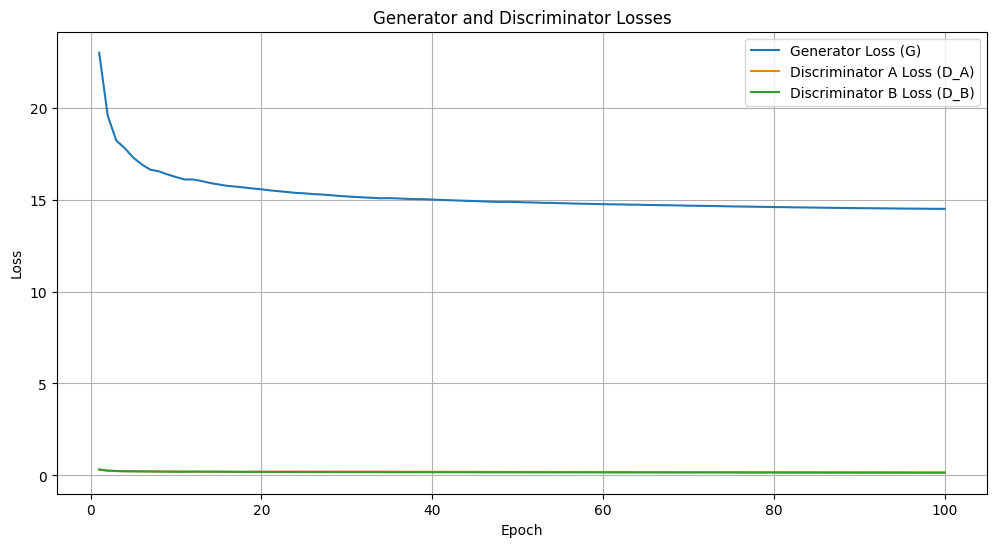

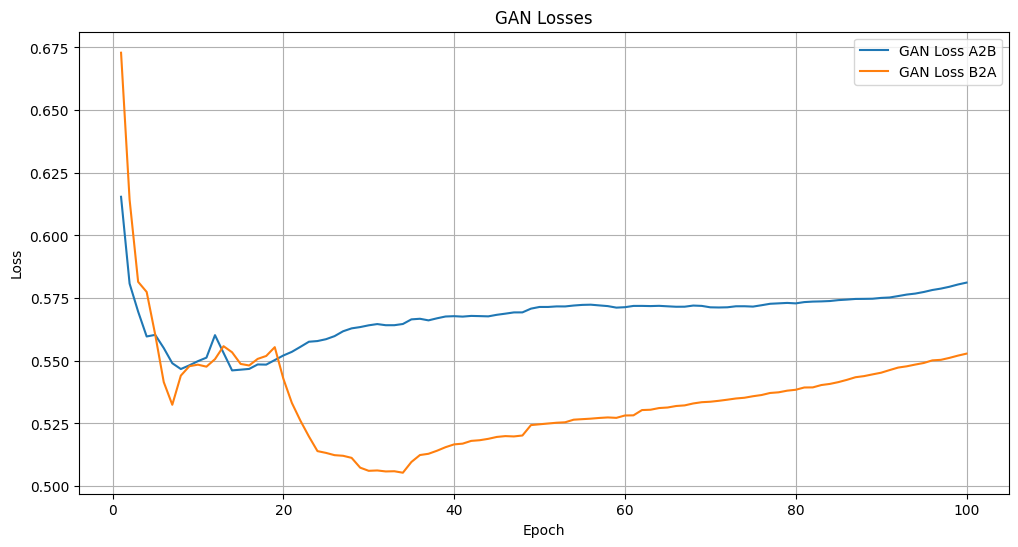

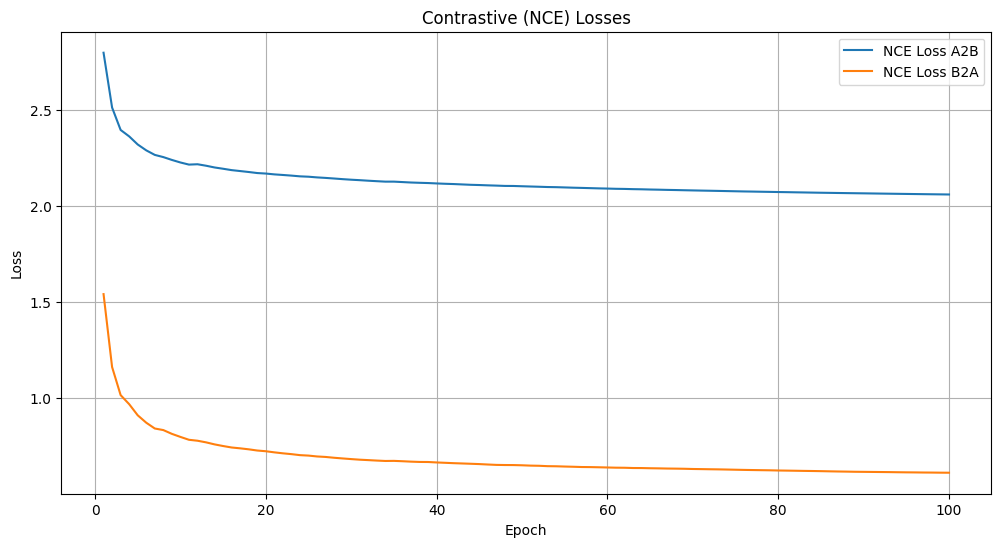

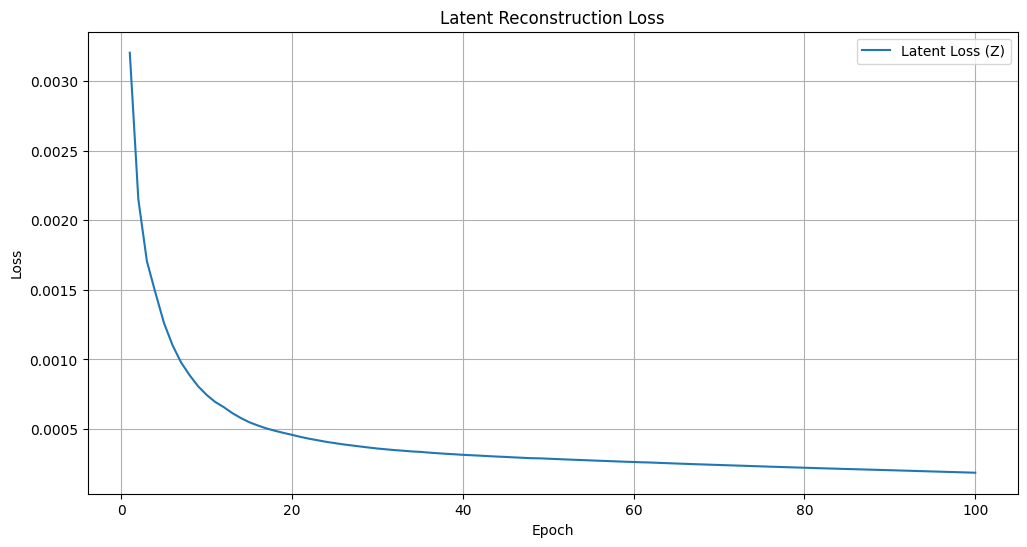

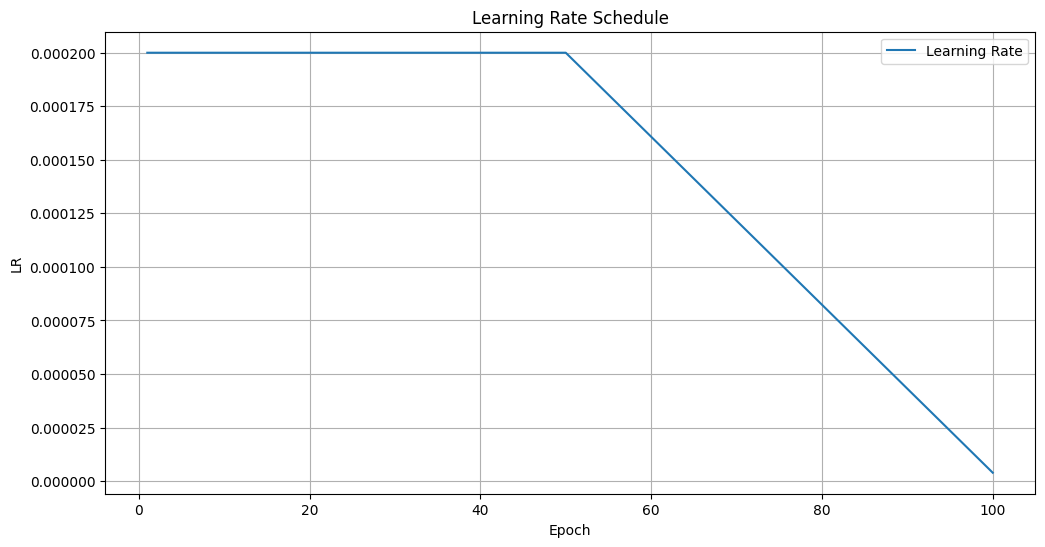

In [19]:
# ---------- Visualization of losses ----------
metrics_df = pd.read_csv(metrics_csv)

plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_G'], label='Generator Loss (G)')
plt.plot(metrics_df['epoch'], metrics_df['loss_D_A'], label='Discriminator A Loss (D_A)')
plt.plot(metrics_df['epoch'], metrics_df['loss_D_B'], label='Discriminator B Loss (D_B)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Generator and Discriminator Losses')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_gan_A2B'], label='GAN Loss A2B')
plt.plot(metrics_df['epoch'], metrics_df['loss_gan_B2A'], label='GAN Loss B2A')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('GAN Losses')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_nce_A2B'], label='NCE Loss A2B')
plt.plot(metrics_df['epoch'], metrics_df['loss_nce_B2A'], label='NCE Loss B2A')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Contrastive (NCE) Losses')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['loss_z'], label='Latent Loss (Z)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Latent Reconstruction Loss')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12, 6))
plt.plot(metrics_df['epoch'], metrics_df['lr'], label='Learning Rate')
plt.xlabel('Epoch'); plt.ylabel('LR'); plt.title('Learning Rate Schedule')
plt.legend(); plt.grid(True); plt.show()

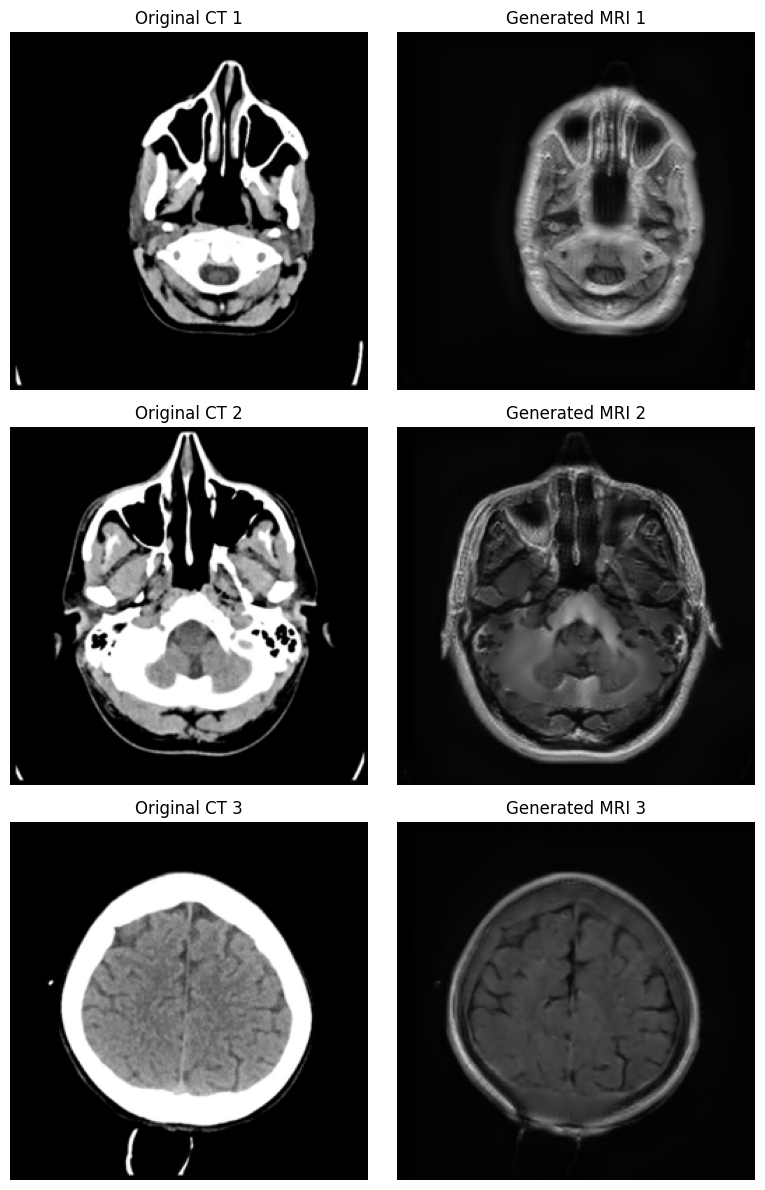

Saved to /kaggle/working/cutgan_outputs/plots/sample_test_pairs.png


In [20]:
# ---------- Sample visualization (3 test pairs) ----------
gen_folder = generated_test_A2B_folder
ct_paths = sorted(glob.glob(os.path.join(TEST_CT_FOLDER, '*.png')) + glob.glob(os.path.join(TEST_CT_FOLDER, '*.jpg')) + glob.glob(os.path.join(TEST_CT_FOLDER, '*.jpeg')))
n_show = min(3, len(ct_paths))
idxs = [0, len(ct_paths)//2, len(ct_paths)-1][:n_show]
selected = [ct_paths[i] for i in idxs]

fig, axs = plt.subplots(n_show, 2, figsize=(8, 4 * n_show))
for i, ct_p in enumerate(selected):
    ct_img = img_to_pil(ct_p).resize((IMAGE_SIZE, IMAGE_SIZE))
    base = os.path.basename(ct_p)
    gen_p = os.path.join(gen_folder, base)
    if not os.path.exists(gen_p):
        continue
    gen_img = Image.open(gen_p).convert('RGB').resize((IMAGE_SIZE, IMAGE_SIZE))
    ax_left = axs[i, 0] if n_show > 1 else axs[0]
    ax_right = axs[i, 1] if n_show > 1 else axs[1]
    ax_left.imshow(ct_img); ax_left.set_title(f'Original CT {i+1}'); ax_left.axis('off')
    ax_right.imshow(gen_img); ax_right.set_title(f'Generated MRI {i+1}'); ax_right.axis('off')

plt.tight_layout()
os.makedirs(os.path.join(OUT_DIR, 'plots'), exist_ok=True)
save_path = os.path.join(OUT_DIR, 'plots', 'sample_test_pairs.png')
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {save_path}')

In [21]:
# ---------- Saliency ----------
def compute_saliency(netG, netD, netE, pil_img, transform):
    netG.eval(); netD.eval(); netE.eval()
    x = transform(pil_img).unsqueeze(0).to(device)
    x.requires_grad_(True)
    with torch.no_grad():
        z, _ = netE(x)
        z_mean = z.mean(dim=1, keepdim=True)
        z_map = z_mean.view(1,1,1,1).expand(1,1,IMAGE_SIZE,IMAGE_SIZE)
    fake = netG(torch.cat([x, z_map], dim=1))
    pred = netD(fake)
    score = pred.mean()
    netG.zero_grad(); netD.zero_grad()
    score.backward()
    grad = x.grad.detach().cpu().squeeze()
    sal = grad.abs().max(0)[0].numpy()
    if sal.max() != sal.min():
        sal = (sal - sal.min()) / (sal.max() - sal.min())
    inp_vis = x.detach().cpu().squeeze()
    img_vis = ((inp_vis + 1.0) / 2.0).permute(1, 2, 0).numpy()
    return sal, img_vis

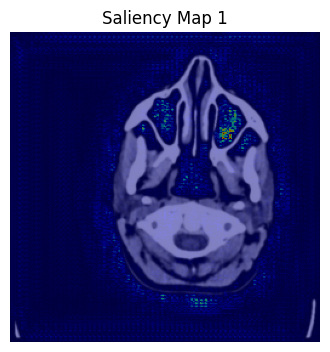

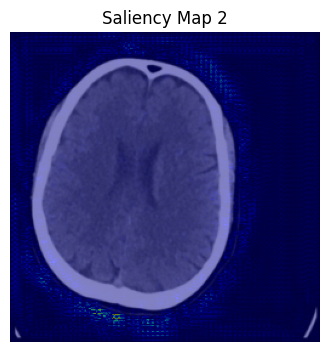

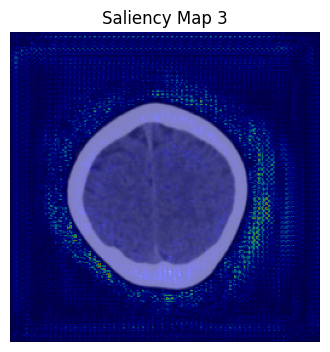

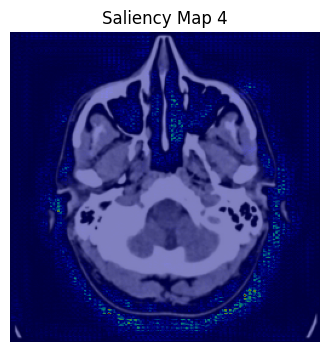

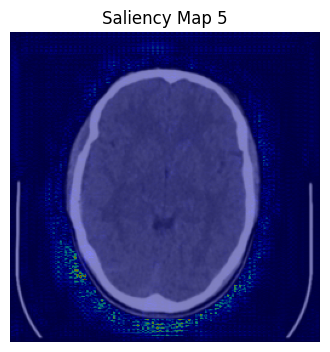

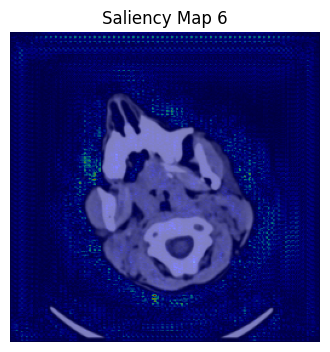

Saliency maps saved to /kaggle/working/cutgan_outputs/xai
Insights: Highlights key regions in CT influencing MRI generation.


In [22]:
# Generate saliency for test samples
xai_folder = os.path.join(OUT_DIR, 'xai')
os.makedirs(xai_folder, exist_ok=True)
ct_paths = sorted(glob.glob(os.path.join(TEST_CT_FOLDER, '*.png')) + glob.glob(os.path.join(TEST_CT_FOLDER, '*.jpg')) + glob.glob(os.path.join(TEST_CT_FOLDER, '*.jpeg')))
if len(ct_paths) > 0:
    n_show = min(6, len(ct_paths))
    step = max(1, len(ct_paths) // n_show)
    idxs = list(range(0, len(ct_paths), step))[:n_show]
    selected = [ct_paths[i] for i in idxs]

    for i, ct_p in enumerate(selected):
        pil_img = img_to_pil(ct_p)
        sal, img_vis = compute_saliency(netG_A2B, netD_B, netE, pil_img, test_transform)
        plt.figure(figsize=(4, 6))
        plt.imshow(img_vis, cmap='gray')
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.axis('off')
        plt.title(f'Saliency Map {i+1}')
        save_path = os.path.join(xai_folder, f'saliency_{i:03d}.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
        plt.close()

    print(f'Saliency maps saved to {xai_folder}')
    print('Insights: Highlights key regions in CT influencing MRI generation.')
else:
    print('No test CT images found.')

In [23]:
# ---- Grad-CAM Class ----
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        all_modules = dict([*model.named_modules()])
        if target_layer not in all_modules:
            raise ValueError(f"Target layer '{target_layer}' not found.")
        self.target_layer = all_modules[target_layer]
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for h in self.hook_handles:
            h.remove()

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        output = self.model(x)
        score = output.mean() if class_idx is None else output[:, class_idx].mean()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        if cam.max() - cam.min() > 1e-6:
            cam = (cam - cam.min()) / (cam.max() - cam.min())
        else:
            cam = np.zeros_like(cam)
        return cam

In [24]:
# ---- Overlay + Show Utility ----
def overlay_heatmap_and_show(img_tensor, heatmap, save_path, title=None):
    img = img_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)
    img_vis = (((img + 1.0) / 2.0) * 255).astype(np.uint8)

    if img_vis.ndim == 2:
        img_vis = cv2.cvtColor(img_vis, cv2.COLOR_GRAY2BGR)
    elif img_vis.shape[2] == 3:
        img_vis = cv2.cvtColor(img_vis, cv2.COLOR_RGB2BGR)

    heatmap_resized = cv2.resize(heatmap, (img_vis.shape[1], img_vis.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_vis, 0.6, heatmap_color, 0.4, 0)

    cv2.imwrite(save_path, overlay)

    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(title if title else "Grad-CAM Overlay")
    plt.axis('off')
    plt.show()

Generating Grad-CAM for 6 test samples...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


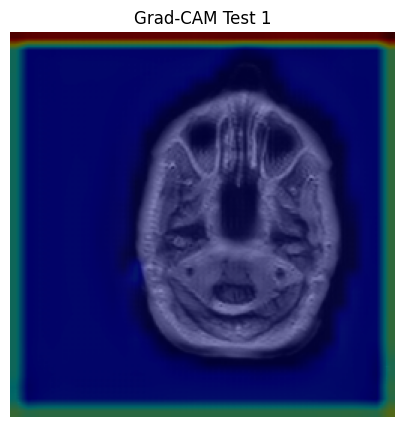

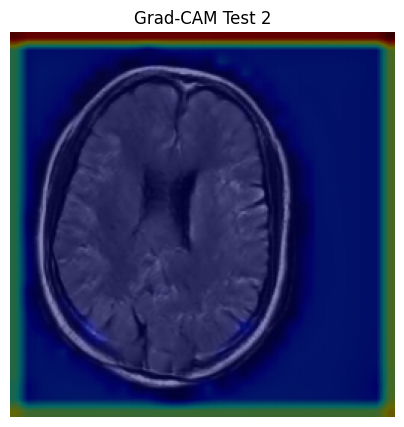

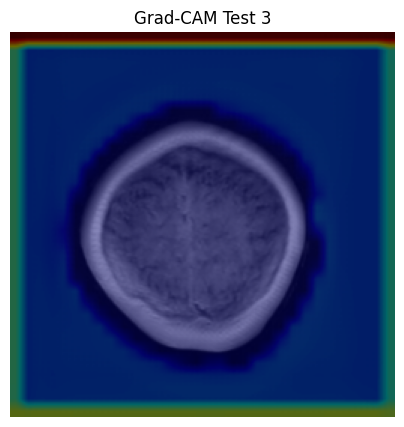

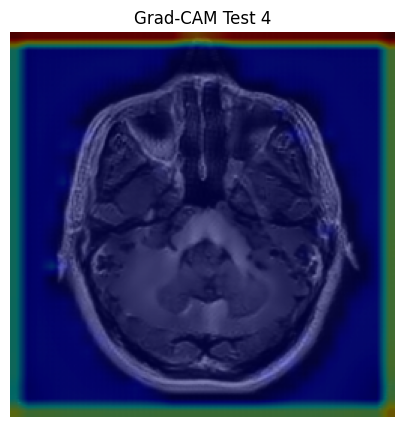

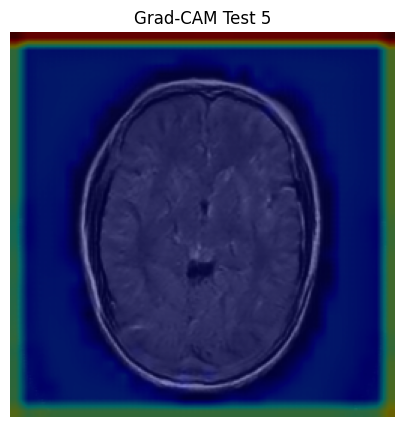

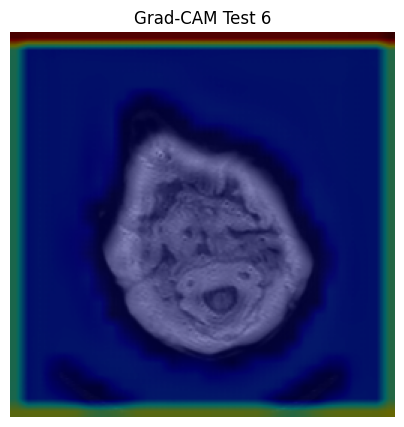

Grad-CAM saved in /kaggle/working/cutgan_outputs/xai_gradcam


In [25]:
# ---- Run Grad-CAM on test samples ----
os.makedirs(os.path.join(OUT_DIR, "xai_gradcam"), exist_ok=True)

netG_A2B.eval(); netD_B.eval(); netE.eval()

try:
    gradcam = GradCAM(netD_B, target_layer='model.7')  # Adjust layer name if needed
except ValueError as e:
    print(f"Skipping Grad-CAM: {e}")
else:
    n_samples = min(6, len(test_dataset))
    step = max(1, len(test_dataset) // n_samples)
    idxs = list(range(0, len(test_dataset), step))[:n_samples]

    print(f"Generating Grad-CAM for {n_samples} test samples...")

    for i, idx in enumerate(idxs):
        sample = test_dataset[idx]
        sample_A = sample["A"].unsqueeze(0).to(device)

        with torch.no_grad():
            z, _ = netE(sample_A)
            z_map = z.mean(dim=1, keepdim=True).view(1, 1, 1, 1).expand(1, 1, IMAGE_SIZE, IMAGE_SIZE)
            fake_translated = netG_A2B(torch.cat([sample_A, z_map], dim=1))
        cam_map = gradcam(fake_translated)

        save_path = os.path.join(OUT_DIR, "xai_gradcam", f"gradcam_test_{i+1}.png")
        overlay_heatmap_and_show(fake_translated, cam_map, save_path, title=f"Grad-CAM Test {i+1}")

    gradcam.remove_hooks()
    print(f"Grad-CAM saved in {os.path.join(OUT_DIR, 'xai_gradcam')}")

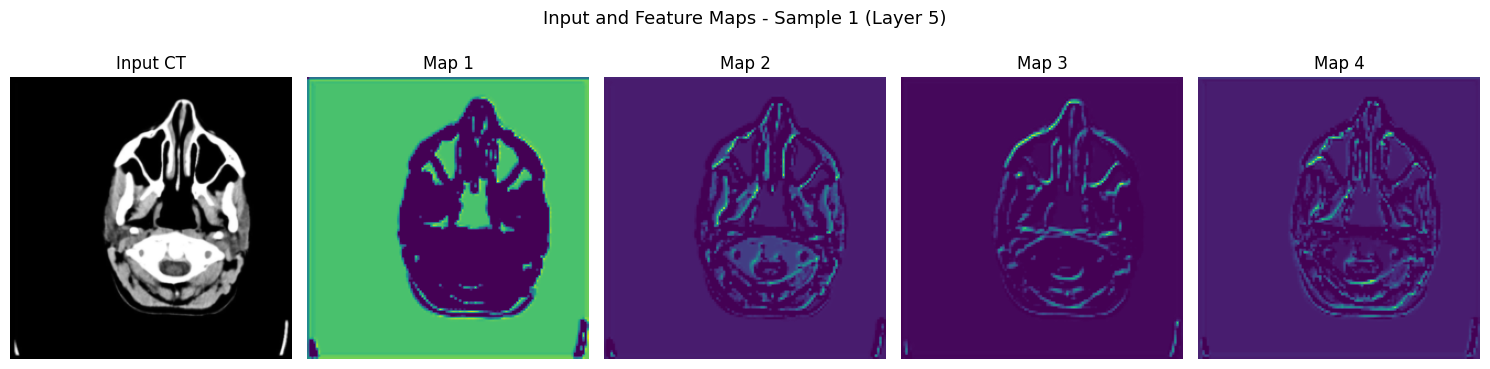

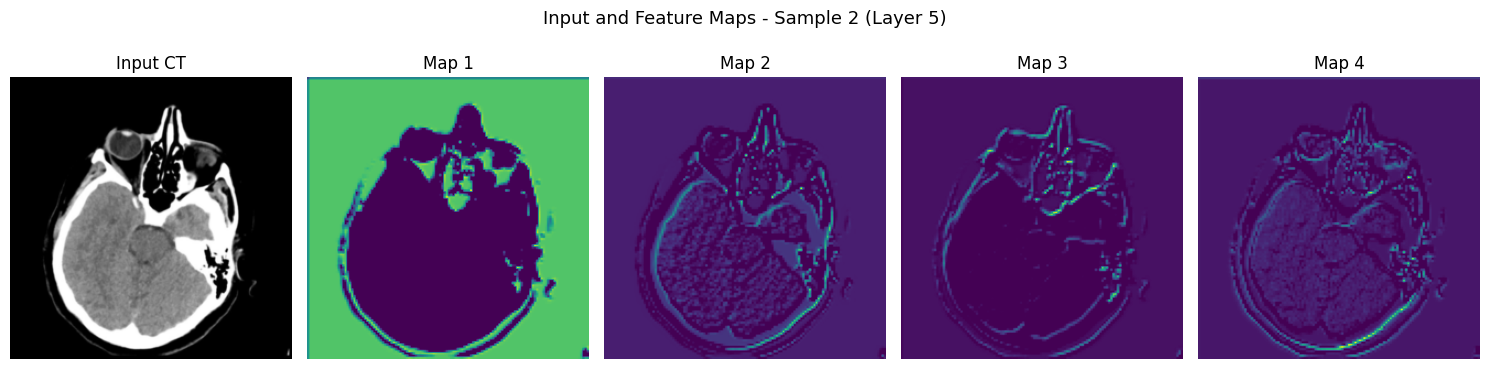

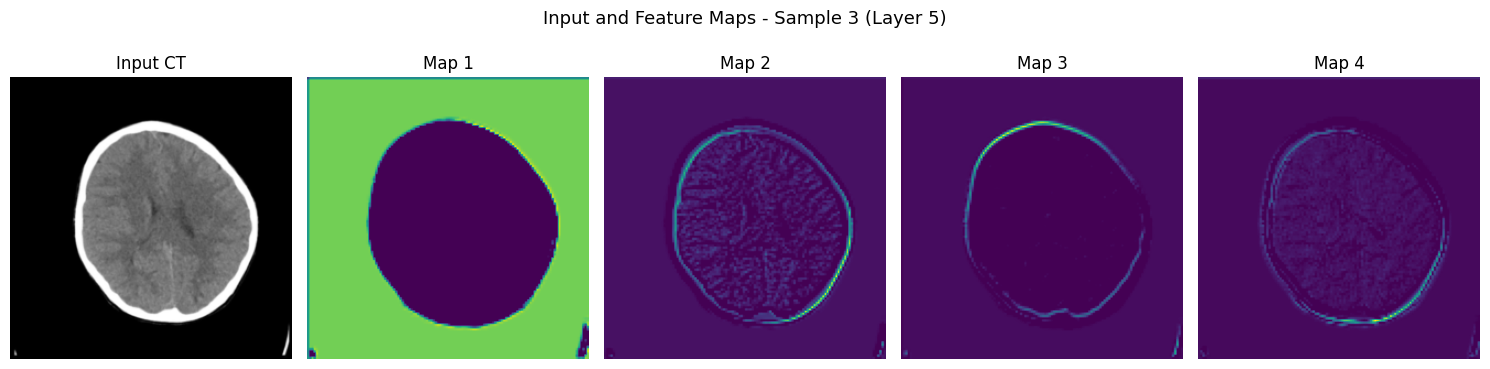

Feature maps saved in: feature_maps


In [26]:
# ---------- Feature Maps Visualization ----------
def visualize_feature_maps(netG_A2B, netE, real_A, device, num_samples=3, layer_index=5, save_dir='feature_maps'):
    os.makedirs(save_dir, exist_ok=True)
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    layer = netG_A2B.model[layer_index]
    hook_handle = layer.register_forward_hook(get_activation(f'layer_{layer_index}'))

    with torch.no_grad():
        z, _ = netE(real_A.to(device))
        z_mean = z.mean(dim=1, keepdim=True)
        z_map = z_mean.view(z_mean.size(0), 1, 1, 1).expand(-1, 1, real_A.size(2), real_A.size(3))

        for i in range(min(num_samples, real_A.size(0))):
            img = real_A[i].unsqueeze(0).to(device)
            z_sample = z_map[i].unsqueeze(0)
            G_input = torch.cat([img, z_sample], dim=1)

            _ = netG_A2B(G_input)
            fmap = activation[f'layer_{layer_index}'].cpu().squeeze(0)

            num_channels = fmap.shape[0]
            n_show = min(4, num_channels)

            img_disp = img[0, :3].cpu().permute(1, 2, 0).numpy()
            img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min() + 1e-8)

            fig, axes = plt.subplots(1, n_show + 1, figsize=(15, 4))
            fig.suptitle(f"Input and Feature Maps - Sample {i+1} (Layer {layer_index})", fontsize=13)

            axes[0].imshow(img_disp)
            axes[0].set_title("Input CT")
            axes[0].axis('off')

            for j in range(n_show):
                axes[j + 1].imshow(fmap[j], cmap='viridis')
                axes[j + 1].set_title(f"Map {j+1}")
                axes[j + 1].axis('off')

            plt.tight_layout()
            plt.show()

            save_path = os.path.join(save_dir, f"sample_{i+1}_layer_{layer_index}.png")
            fig.savefig(save_path, dpi=150, bbox_inches='tight')
            plt.close(fig)

    hook_handle.remove()
    print(f"Feature maps saved in: {save_dir}")

# Fetch a sample batch from test loader for visualization
for batch in test_dataloader:
    real_A_sample = batch['A'][:3]  # Take 3 samples
    break

visualize_feature_maps(netG_A2B, netE, real_A_sample, device, num_samples=3, layer_index=5)